# Sensor shape optimization workflow

In this example we will show how to use MaMMoS for shape optimization of a magnetic sensor element. To show the versatility of the mammos software we will perform the micromagnetic simulations with the `ubermag` micromagnetic package.

In this workflow we optimize the region of the hysteresis loop over which M vs H has a linear reponse. In order to do this we will first obtain micromagnetic parameters, perform micromagnetic simulations, and then analyze the hysteresis loop.

This is followed by Baysian optimization to maximize the linear region.

Requirements:
- Software: `mammos`, `ubermag` with OOMMF, `bayesian-optimization`
- Basic understanding of [mammos-units](https://mammos-project.github.io/mammos/examples/mammos-units/quickstart.html) and [mammos-entity](https://mammos-project.github.io/mammos/examples/mammos-entity/quickstart.html)

In [1]:
%config InlineBackend.figure_format = "retina"

# MaMMoS imports
# Ubermag imports
import discretisedfield as df
import mammos_analysis
import mammos_entity as me
import mammos_spindynamics
import mammos_units as u
import micromagneticdata as md
import micromagneticmodel as mm
import numpy as np
import oommfc as mc

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
# Allow convenient conversions between A/m and T
u.set_enabled_equivalencies(u.magnetic_flux_field());

## Temperature-dependent magnetization data from spindynamics database lookup

In order to get micromagnetic parameters we use pre-computed data from `mammos_spindynamics.db` for the temperature-dependent magnetization.

In [4]:
results_spindynamics = mammos_spindynamics.db.get_spontaneous_magnetization("Ni80Fe20")

We can visualize the pre-computed data using `.plot`.

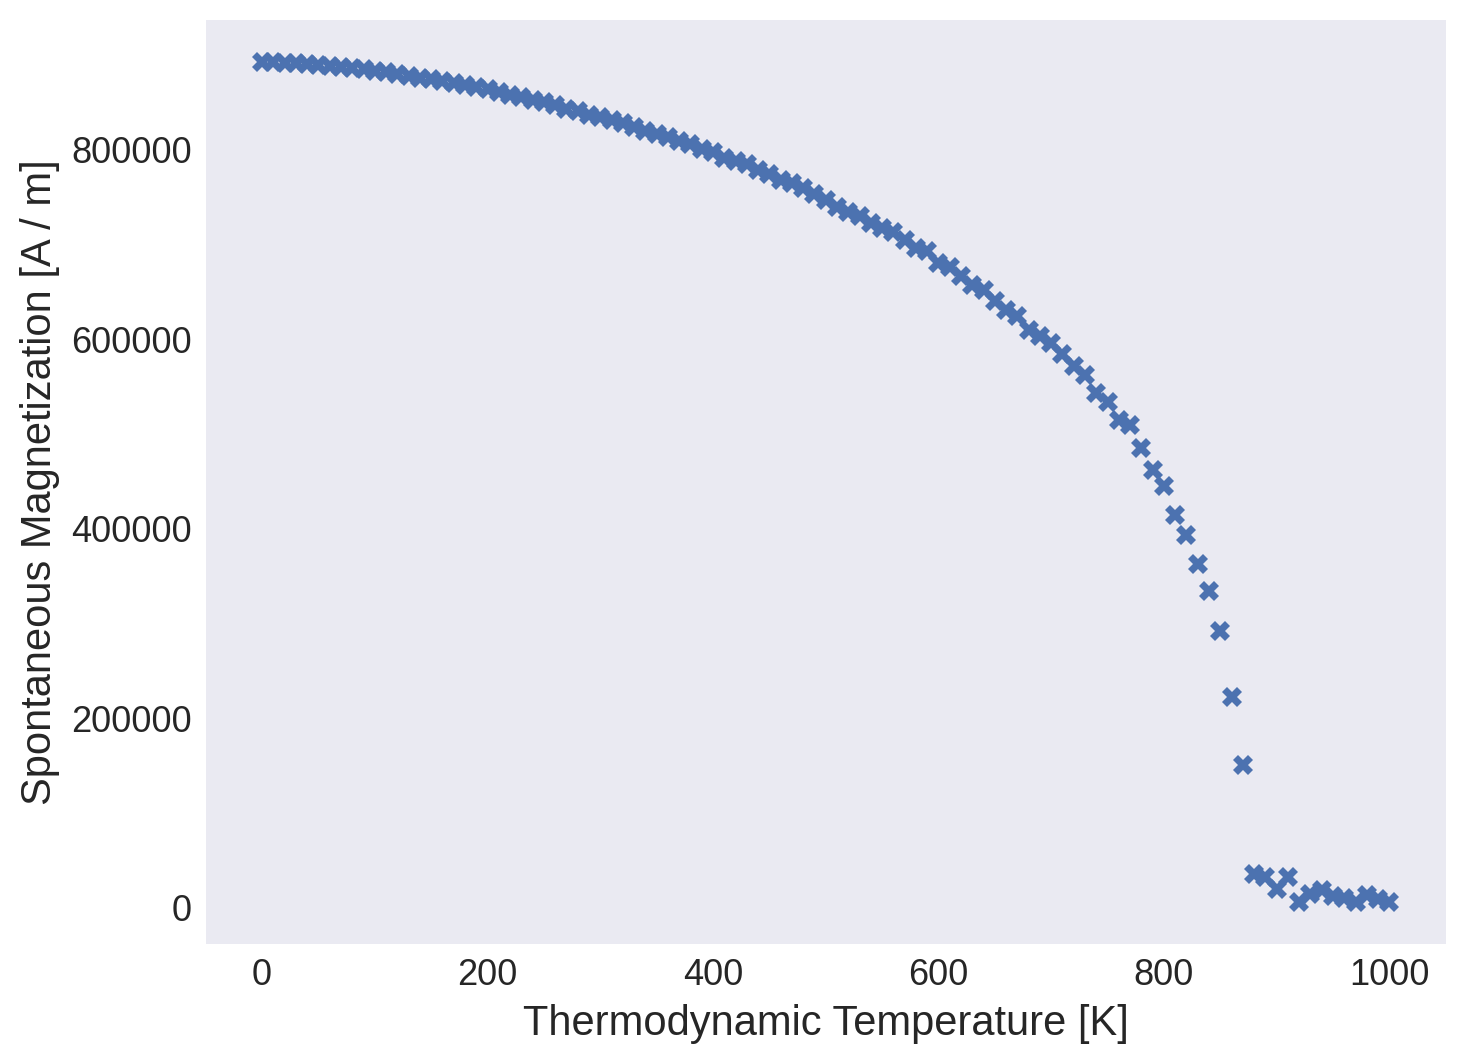

In [5]:
results_spindynamics.plot(marker="X");

We can access `T` and `Ms` and get `mammos_entity.Entity` objects:

In [6]:
results_spindynamics.T

ThermodynamicTemperature(value=
[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.
  240.  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.
  360.  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.
  480.  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.
  600.  610.  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.
  720.  730.  740.  750.  760.  770.  780.  790.  800.  810.  820.  830.
  840.  850.  860.  870.  880.  890.  900.  910.  920.  930.  940.  950.
  960.  970.  980.  990. 1000.],
 unit=K)

In [7]:
results_spindynamics.Ms

SpontaneousMagnetization(value=
[892184.69121101 891969.67470043 891513.76832322 890894.59214752
 890083.59626321 889199.44123422 888171.64446995 887053.73705186
 885671.74296517 884395.91885674 883079.94643721 881495.42642562
 879788.67711133 877788.39903363 875834.51455988 874081.37164165
 872049.86709976 869912.19257962 867442.62535435 865562.79220997
 863209.20899455 860457.71140686 857763.3136394  855296.4229682
 852466.41312768 849523.98801607 846414.7243672  842904.86979197
 840148.91128082 836734.52046756 833918.7855821  830963.86988481
 827691.33643744 824071.7431452  819584.05414841 816187.50702897
 812565.23718265 809168.69006321 805466.12359469 800465.42840045
 796733.41983711 791036.82058373 787268.23244806 784894.12898474
 777771.81859481 774073.71304974 767972.95413124 764328.37966764
 758786.12836584 752673.77104635 746867.43307595 739287.43193942
 734194.84172199 730168.41221055 722195.84980989 716598.28305723
 712643.22832109 704576.09434316 696401.89820229 692470.932

## Calculate micromagnetic intrinsic properties using Kuz’min formula

We use Kuz’min equations to compute Ms(T) and A(T).

In [8]:
kuzmin_result = mammos_analysis.kuzmin_properties(
    T=results_spindynamics.T,
    Ms=results_spindynamics.Ms,
)

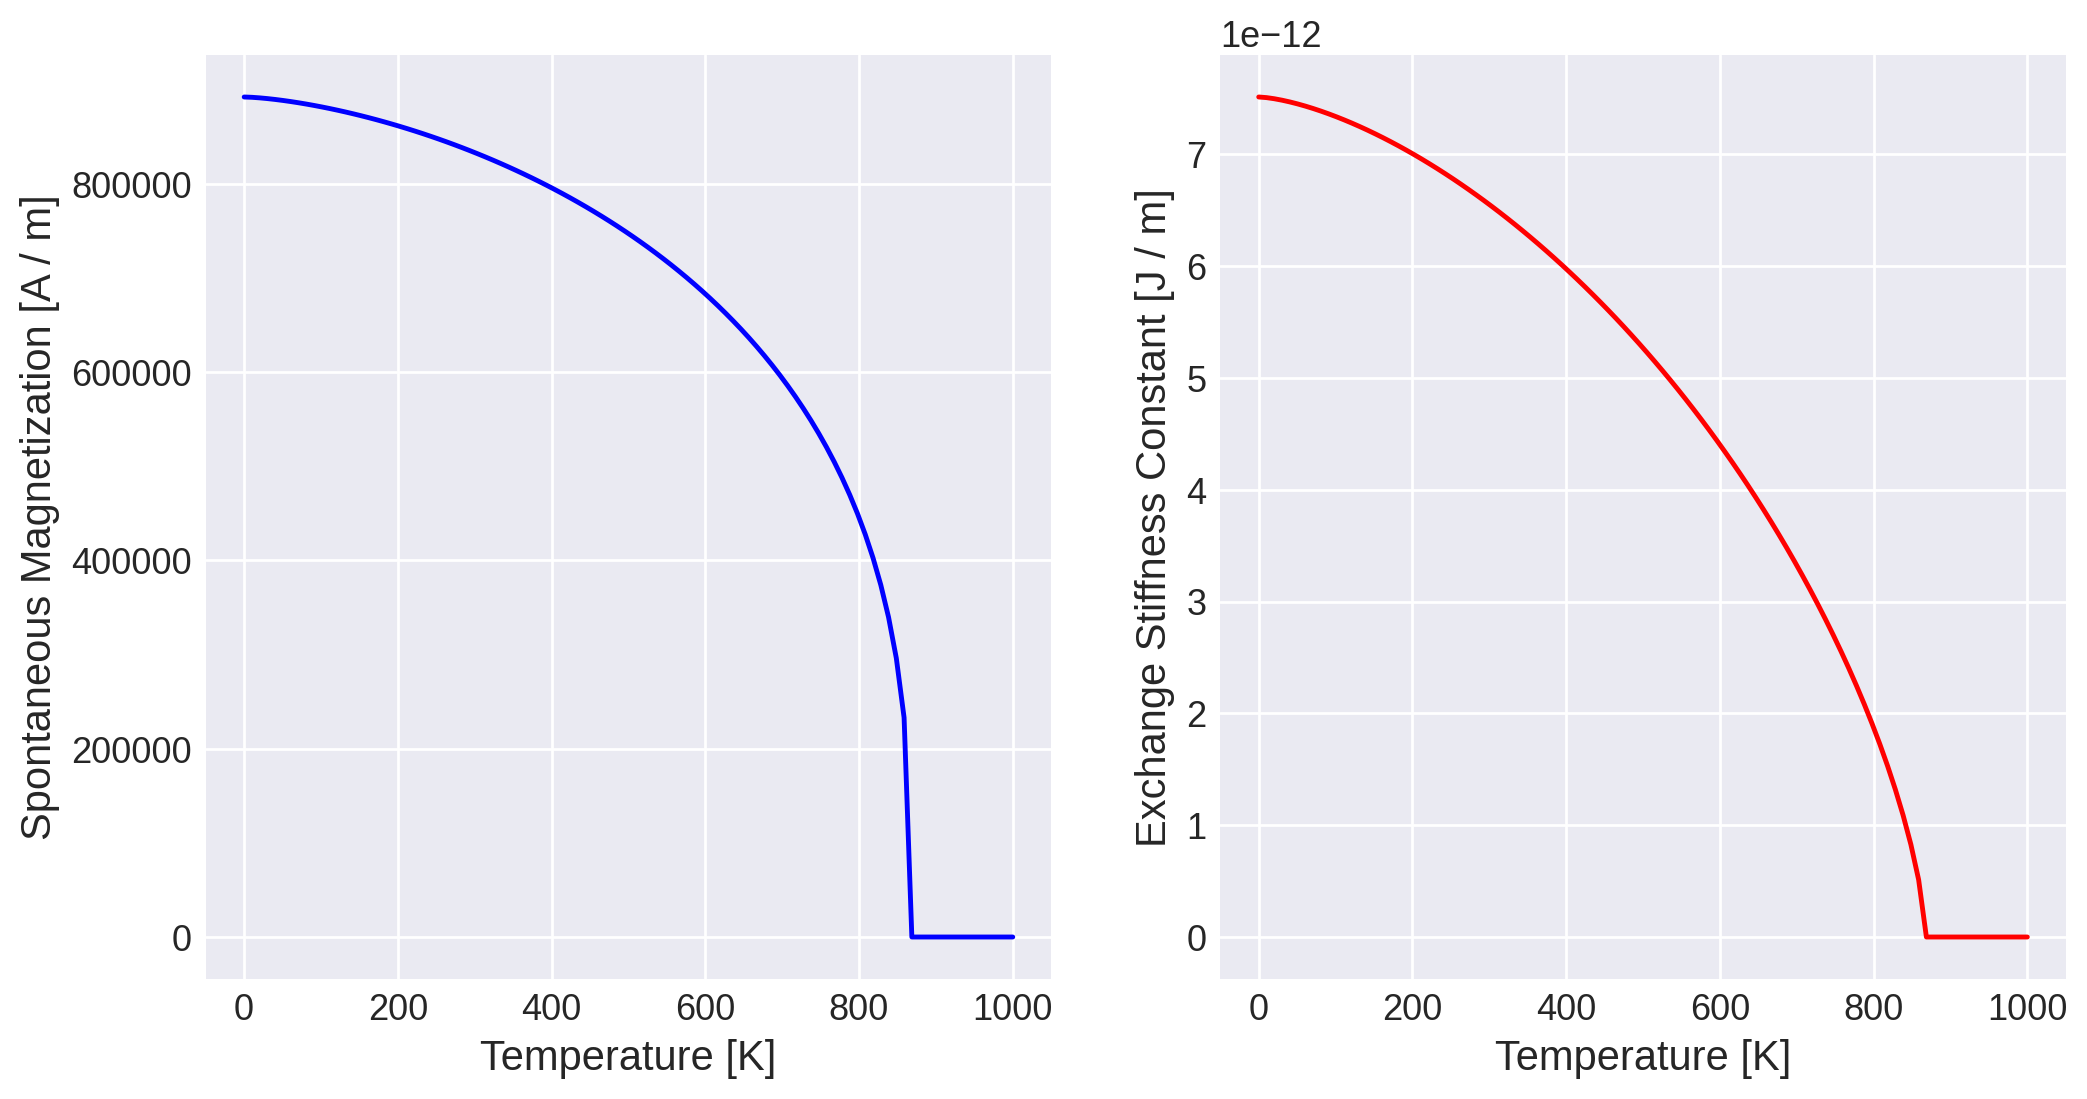

In [9]:
kuzmin_result.plot();

In [10]:
kuzmin_result

KuzminResult(Ms=Ms(T), A=A(T), Tc=CurieTemperature(value=868.103292637747, unit=K), s=<Quantity 0.86884674>, K1=None)

In [11]:
kuzmin_result.Ms(0)

SpontaneousMagnetization(value=892184.691211015, unit=A / m)

In [12]:
kuzmin_result

KuzminResult(Ms=Ms(T), A=A(T), Tc=CurieTemperature(value=868.103292637747, unit=K), s=<Quantity 0.86884674>, K1=None)

In [13]:
kuzmin_result.Ms(0)

SpontaneousMagnetization(value=892184.691211015, unit=A / m)

## Setting up the micromagnetic simulation
Run the micromagnetic simulation with parameters at 300 K using [ubermag](https://ubermag.github.io) with OOMMF as calculator.

In [14]:
T = me.T(300, unit="K")

Define the energy equation of the system.

In [15]:
system = mm.System(name="sensor")
A = kuzmin_result.A(T)  # TODO: change when material is updated
Ms = kuzmin_result.Ms(T)  # TODO: change when material is updated
system.energy = mm.Exchange(A=A.value) + mm.Demag() + mm.Zeeman(H=(0, 0, 0))

Initialize the magnetization: we constrain the shape of our sensor to be a diamond (rhombus) with the distance $s_x$ and $s_y$  from origin to corners along the $x$ and $y$ directions, respectively, and with thickness $t$. We create a $100\times 100\times 5$ nm region in which we create the diamond shape of magnetic material.

In [16]:
L = 100e-9  # nm
t = 5e-9  # nm
region = df.Region(p1=(-L / 2, -L / 2, -t / 2), p2=(L / 2, L / 2, t / 2))
mesh = df.Mesh(region=region, n=(40, 40, 1))


def in_diamond(position, sx, sy):
    x, y, _ = position
    if abs(x) / sx + abs(y) / sy <= 1:
        return Ms.value
    else:
        return 0


system.m = df.Field(mesh, nvdim=3, value=(1, 0, 0), norm=lambda p: in_diamond(p, 40e-9, 30e-9), valid="norm")

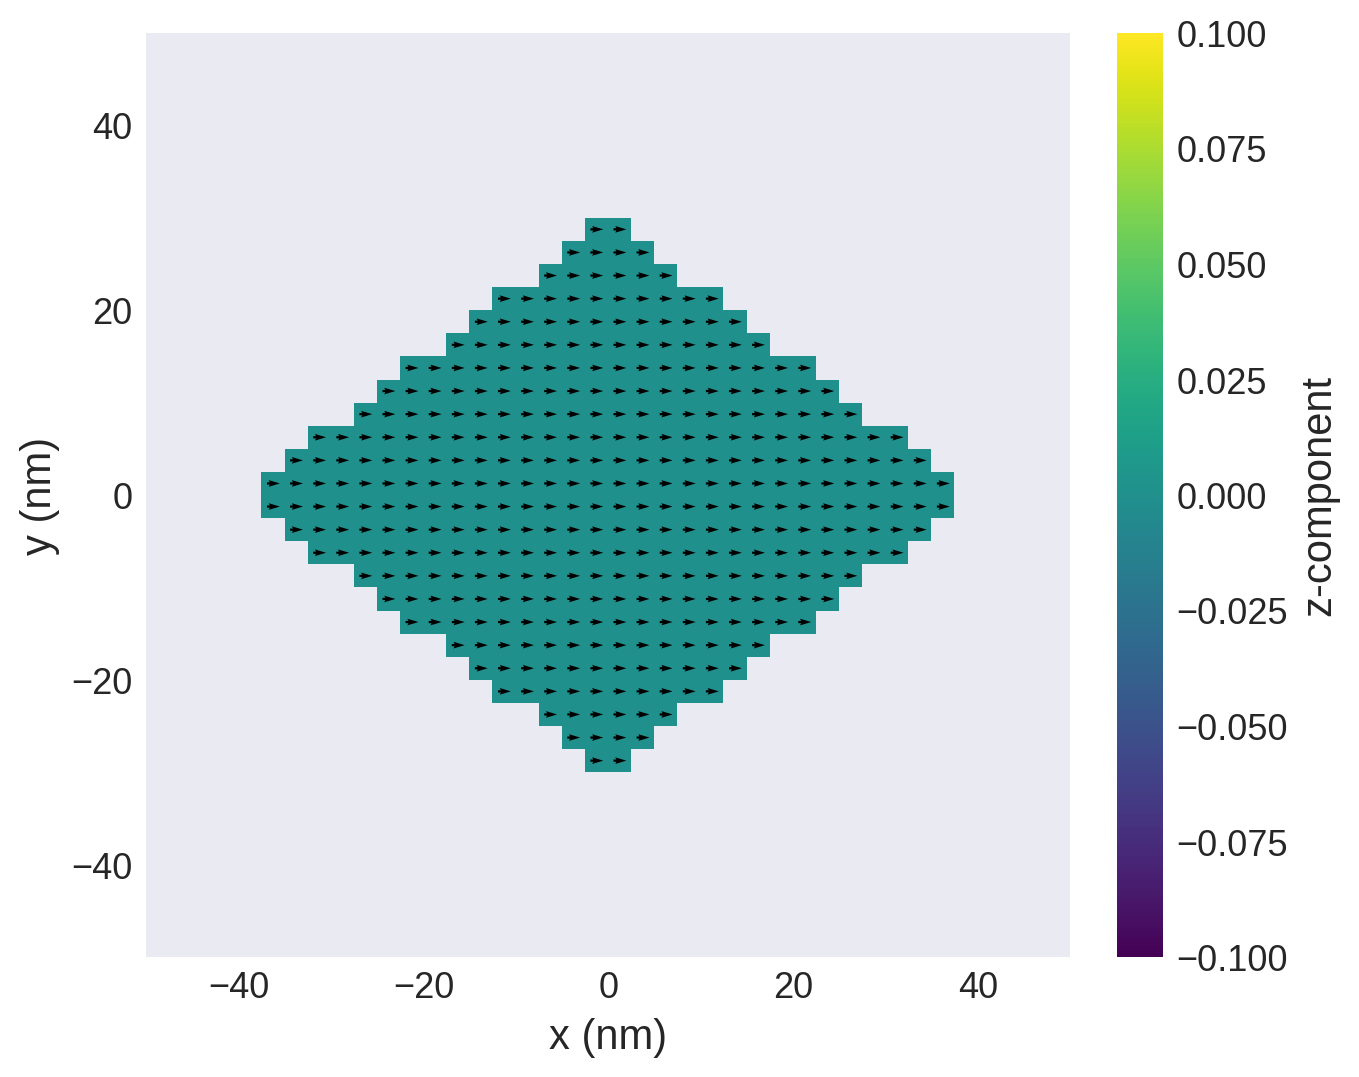

In [17]:
system.m.sel("z").mpl()

Run a hystersis loop from 0 to 500 mT in the y direction:

In [18]:
Hmin = (0, 0, 0)
Hmax = ((0.1, 500, 0) * u.mT).to(u.A / u.m)  # Convert to A/m for Ubermag compatibility
n = 101

hd = mc.HysteresisDriver()
hd.drive(system, Hsteps=[[Hmin, tuple(Hmax.value), n]])

Running OOMMF (ExeOOMMFRunner)[2025-06-04T17:34:34]... (7.4 s)


Extract entitles from the results of our field sweep:

In [19]:
H_y = me.H(
    system.table.data["By_hysteresis"].values  # simulation output in mT
    * u.Unit(system.table.units["By_hysteresis"]).to(u.A / u.m)  # conversion factor from mT to A/m
)
M_y = me.Entity("Magnetization", system.table.data["my"].values * Ms)

## Linear segment
Use `mammos-analysis` to find the properties of the linearized hysteresis loop.

In [20]:
results_linear = mammos_analysis.hysteresis.find_linear_segment(H_y, M_y, margin=0.05 * Ms, min_points=5)

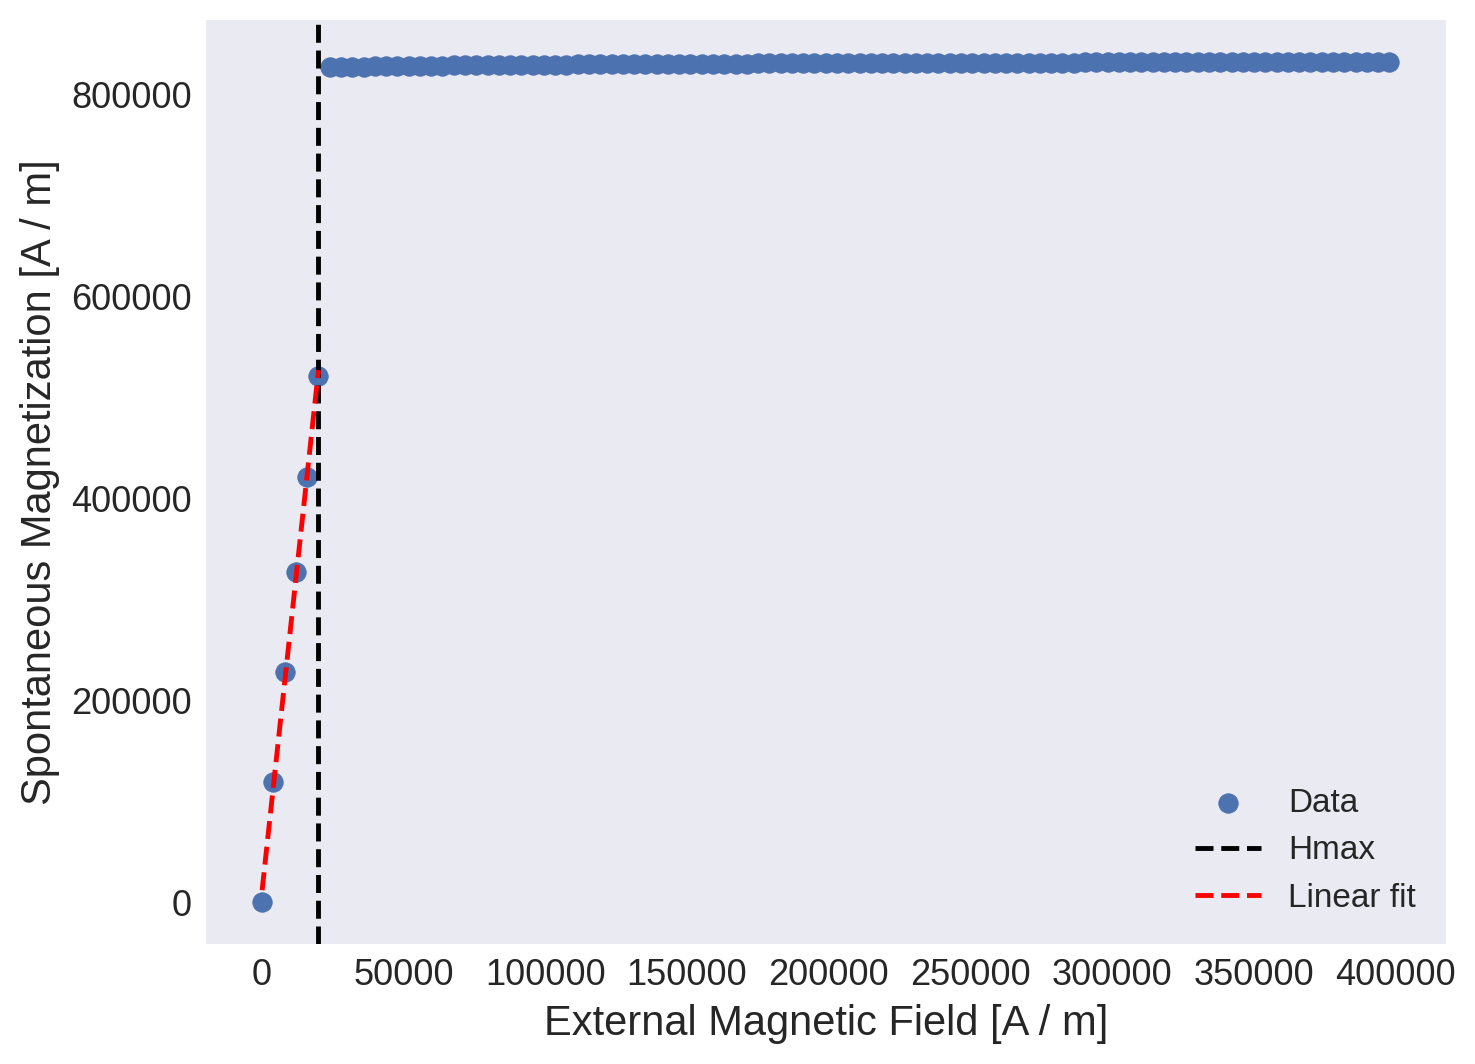

In [21]:
results_linear.plot();

In [22]:
results_linear.Hmax  # maximum field value of the linear region

ExternalMagneticField(value=19894.36786483437, unit=A / m)

In [23]:
results_linear.Mr  # crossing of linear fit and y axis

Remanence(value=11682.77113749185, unit=A / m)

In [24]:
results_linear.gradient  # slope of the linear fit

<Quantity 25.89453972>

## Optimization

Here we use Bayesian optimization to maximize `Hmax` by optimizing the lengths of the diagnonals $s_x$ and $s_y$ of the diamond.

In [25]:
from bayes_opt import BayesianOptimization

Define the objective function:

In [26]:
def objective(sx, sy):
    system.m = df.Field(
        mesh, nvdim=3, value=(1, 0, 0), norm=lambda p: in_diamond(p, sx, sy), valid="norm"
    )  # Change shape
    hd.drive(system, Hsteps=[[Hmin, tuple(Hmax.value), n]], verbose=0)  # Field sweep
    H_y = me.H(system.table.data["By_hysteresis"].values * u.Unit(system.table.units["By_hysteresis"]).to(u.A / u.m))
    M_y = system.table.data["my"].values * Ms
    results_linear = mammos_analysis.hysteresis.find_linear_segment(
        H_y, M_y, margin=0.05 * Ms, min_points=2
    )  # Find linear segment
    return results_linear.Hmax.value

In [27]:
objective(19e-9, 39e-9)

3978.8735729668742

Running the simulation changes the `system` so we can view the new shape using:

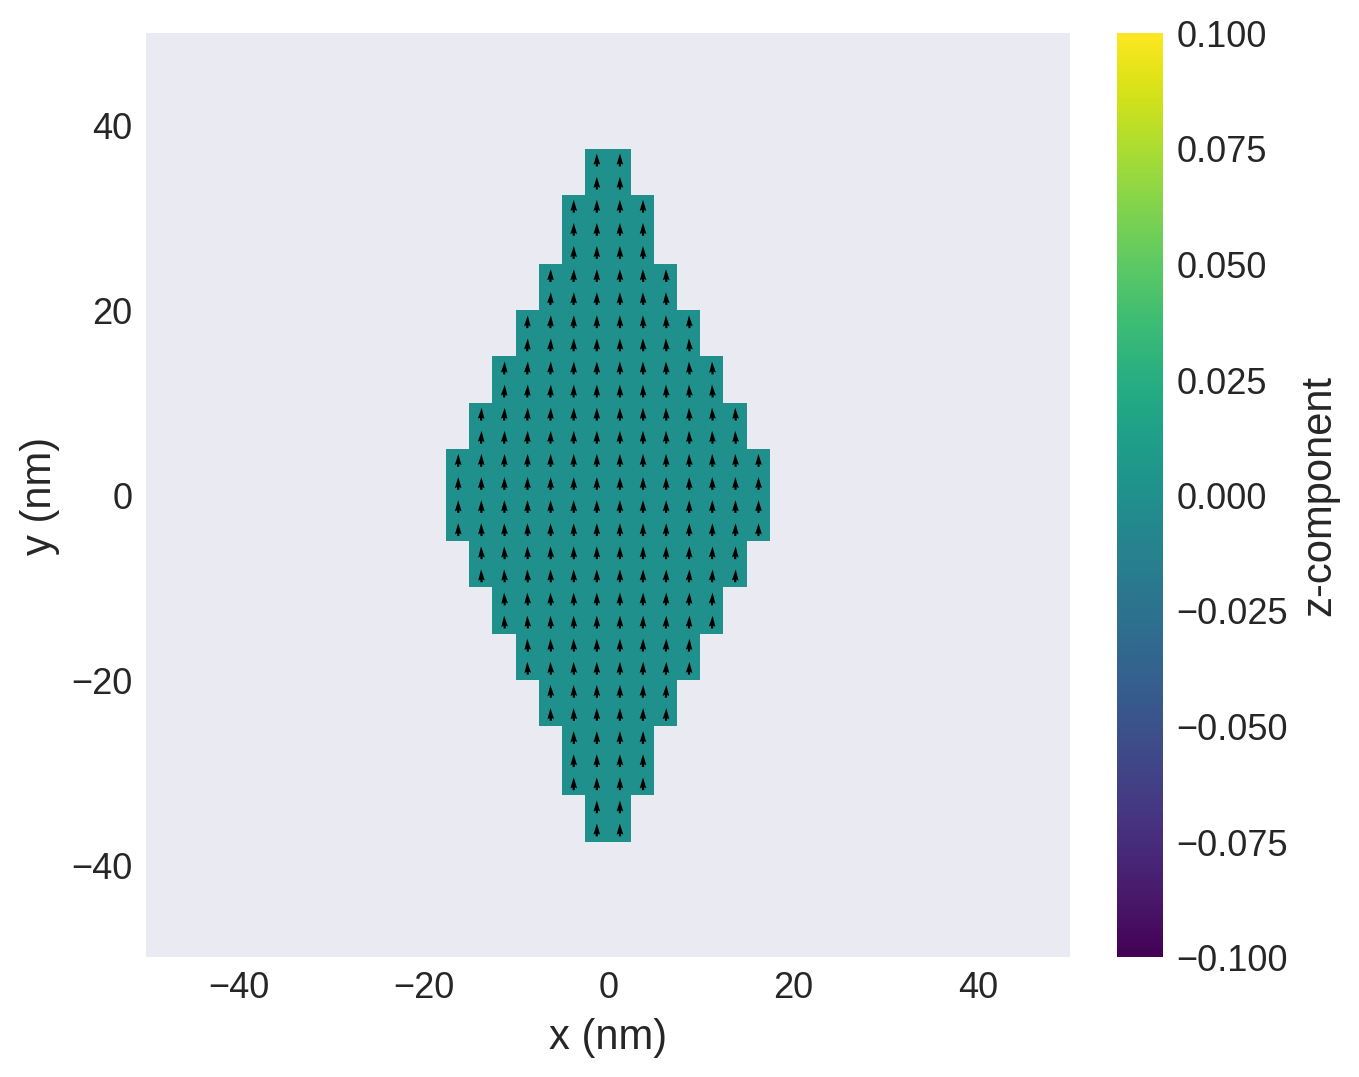

In [28]:
system.m.sel("z").mpl()

We define the bounds over which the optimizer can search:

In [29]:
pbounds = {"sx": (3e-9, np.sqrt(2) * 50e-9), "sy": (3e-9, np.sqrt(2) * 50e-9)}

Initialize the optimizer:

In [30]:
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

We maximize the objective function:

In [31]:
optimizer.maximize(
    init_points=10,
    n_iter=20,
)

|   iter    |  target   |    sx     |    sy     |
-------------------------------------------------
| 1         | 3.979e+03 | 3.124e-08 | 5.177e-08 |
| 2         | 3.979e+03 | 3.008e-09 | 2.347e-08 |
| 3         | 5.173e+04 | 1.294e-08 | 9.252e-09 |
| 4         | 3.979e+03 | 1.561e-08 | 2.64e-08  |
| 5         | 3.979e+03 | 2.987e-08 | 3.948e-08 |
| 6         | 3.979e+03 | 3.138e-08 | 4.94e-08  |
| 7         | 3.979e+03 | 1.684e-08 | 6.246e-08 |
| 8         | 3.979e+03 | 4.854e-09 | 4.84e-08  |
| 9         | 3.979e+03 | 3.126e-08 | 4.083e-08 |
| 10        | 3.979e+03 | 1.251e-08 | 1.641e-08 |
| 11        | 3.979e+05 | 6.878e-08 | 3.093e-09 |
| 12        | 3.979e+05 | 7.033e-08 | 3.693e-09 |
| 13        | 3.979e+05 | 7.042e-08 | 3.294e-09 |
| 14        | 3.979e+05 | 7.051e-08 | 3.277e-09 |
| 15        | 3.979e+05 | 7.065e-08 | 3.624e-09 |
| 16        | 3.979e+05 | 7.022e-08 | 3.215e-09 |
| 17        | 3.979e+05 | 7.007e-08 | 3.54e-09  |
| 18        | 3.979e+05 | 7.06e-08  | 3.728e-09 |


In [32]:
print(optimizer.max)

{'target': 397887.35729668743, 'params': {'sx': 6.878354081128767e-08, 'sy': 3.092785135534182e-09}}


Lets run the simulation again with the best values to check the simulation and the shape.

In [33]:
sx, sy = optimizer.max["params"]["sx"], optimizer.max["params"]["sy"]
system.m = df.Field(mesh, nvdim=3, value=(1, 0, 0), norm=lambda p: in_diamond(p, sx, sy), valid="norm")  # Change shape
hd.drive(system, Hsteps=[[Hmin, tuple(Hmax.value), n]], verbose=0)  # Field sweep
H_y = me.H(system.table.data["By_hysteresis"].values * u.Unit(system.table.units["By_hysteresis"]).to(u.A / u.m))
M_y = system.table.data["my"].values * Ms
results_linear = mammos_analysis.hysteresis.find_linear_segment(
    H_y, M_y, margin=0.01 * Ms, min_points=2
)  # Find linear segment

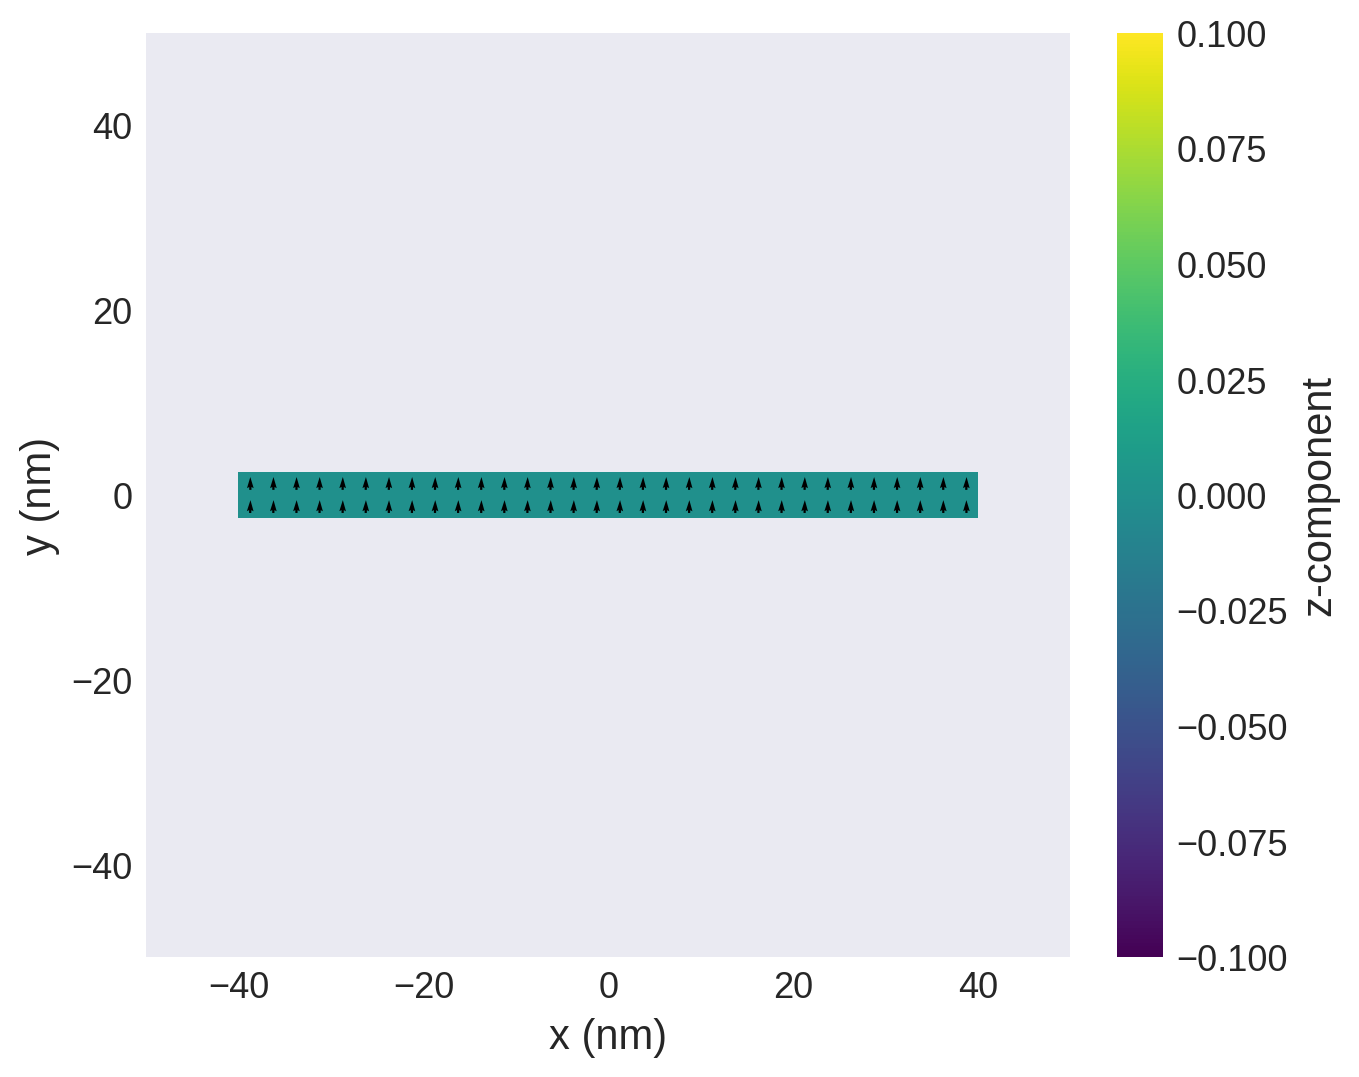

In [34]:
system.m.sel("z").mpl()

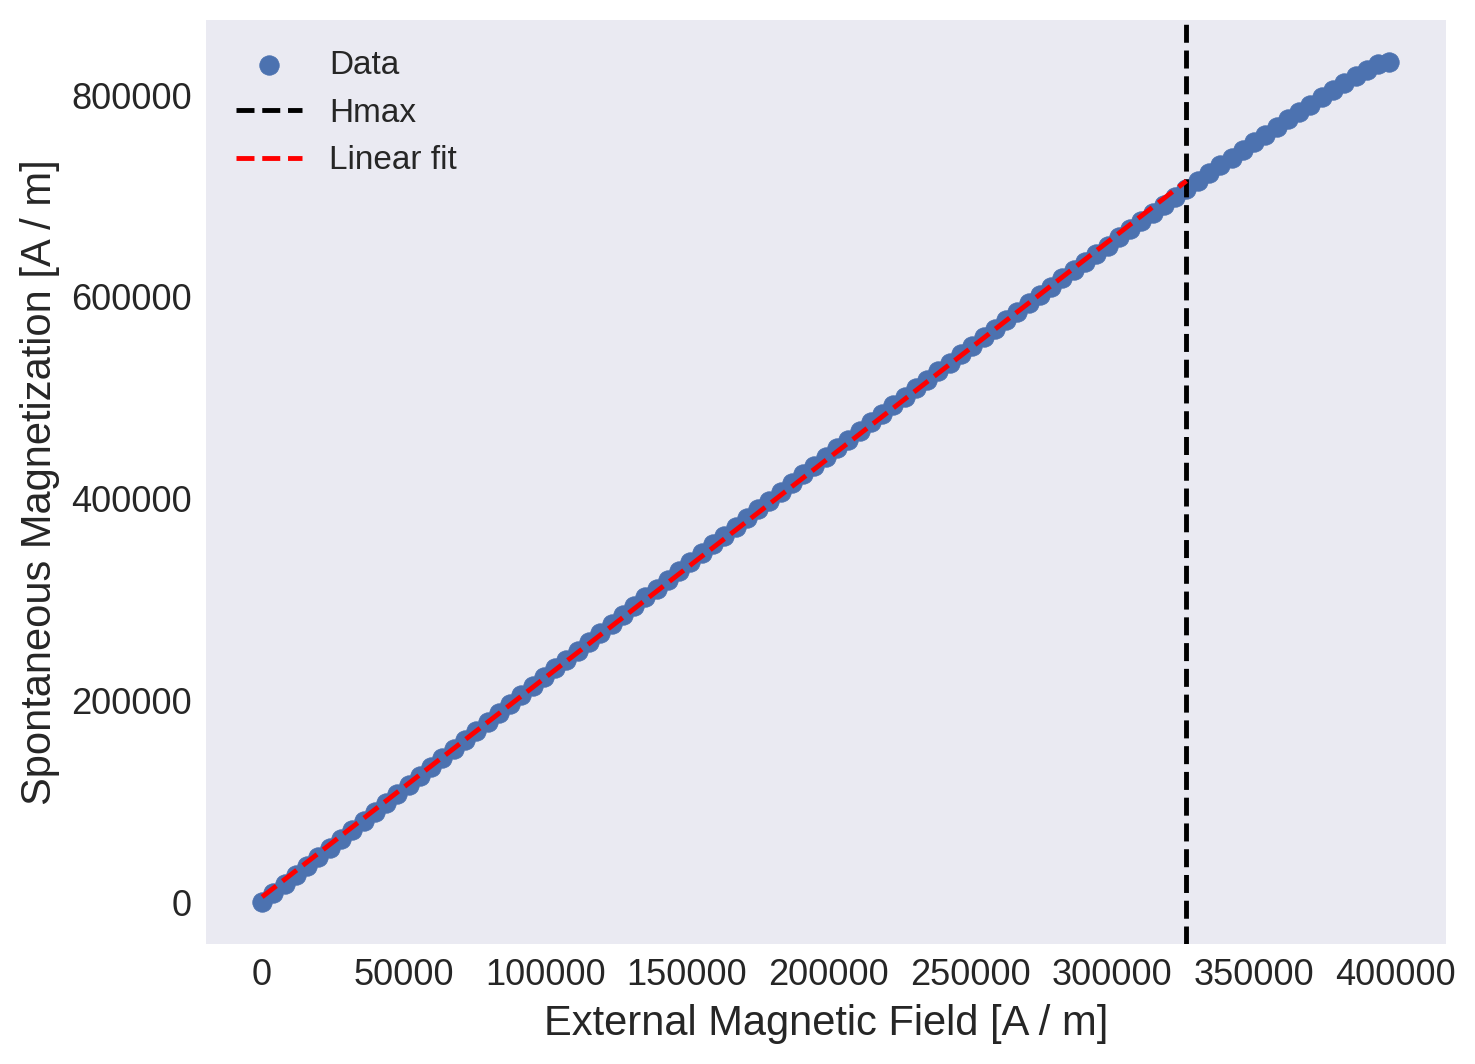

In [35]:
results_linear.plot();

We can also use the built in tools of `ubermag` to visualize the magnetization as a function of applied field directly. 

In [36]:
data = md.Data(system.name)

drive = data[-1]

drive.hv(kdims=["x", "y"])

:DynamicMap   [B_hysteresis]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)